In [1]:
%load_ext autoreload
%autoreload 2

import json
import w3d2_tests
import transformers
import torch
import torch as t
from torch import nn
import einops
import matplotlib.pyplot as plt

model = w3d2_tests.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("test_tokens_owt_subset.json") as f:
    test_tokens = torch.LongTensor(json.load(f))[:,:512]


In [2]:
class UniAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.project_qkv = nn.Linear(hidden_size, hidden_size * 3, bias=False)
        self.project_output = nn.Linear(hidden_size, hidden_size, bias=False)
        
        self.hidden_size = hidden_size
        self.head_size = hidden_size // num_heads
        self.n_heads = num_heads

    def forward(self, x: t.Tensor, pos_embedding):
        batch, seq_len = x.shape[:2]
        pos_ids = t.arange(x.shape[1]).unsqueeze(0).to(x.device)
        pos_emb = pos_embedding(pos_ids)

        q, k, _ = t.split(self.project_qkv(x + pos_emb), self.hidden_size, dim=-1)
        _, _, v = t.split(self.project_qkv(x), self.hidden_size, dim=-1)
        
        q = einops.rearrange(q, 'b n (h l) -> b h n l', l=self.head_size)
        k = einops.rearrange(k, 'b n (h l) -> b h n l', l=self.head_size)
        v = einops.rearrange(v, 'b n (h l) -> b h n l', l=self.head_size)
        
        neg_inf = t.tensor(-1e4).to(x.device)
        q_ind = t.arange(seq_len).unsqueeze(1)
        k_ind = t.arange(seq_len).unsqueeze(0)
        mask = (q_ind < k_ind).to(x.device)
        attn_scores = t.einsum('bhql, bhkl -> bhqk', q, k) / math.sqrt(self.head_size)
        attn_scores = t.where(mask, neg_inf, attn_scores)

        self._attn_scores = attn_scores.detach()[0]
        probs = attn_scores.softmax(dim=-1)
        combined_v = t.einsum('bhqk, bhkl -> bhql', probs, v)
        combined_v = einops.rearrange(combined_v, 'b h q l -> b q (h l)')
        self._combined_v = combined_v
        out = self.project_output(combined_v)
        return out


In [3]:
# class MiniGPT(nn.Module):
#     def __init__(self, num_heads=8, vocab_size=50259, hidden_size=256,
#                  max_position_embeddings=512):
#         super().__init__()
#         self.token_embedding = nn.Embedding(vocab_size, hidden_size)
#         self.pos_embedding = nn.Embedding(max_position_embeddings, hidden_size)
#         self.blocks = nn.Sequential(
#             UniAttention(hidden_size, num_heads),
#             UniAttention(hidden_size, num_heads),
#         )
        
#     def forward(self, input_ids):
#         emb = self.token_embedding(input_ids)
#         for block in self.blocks:
#             emb = emb + block(emb, self.pos_embedding)
#         return t.einsum('bnl, vl -> bnv', emb, self.token_embedding.weight)

    
    
def weight_matrix(model, qkvo: str, layer: int, head: int):
    layer = model.blocks[layer]
    if qkvo == 'o':
        res = layer.project_output.weight[:, head*layer.head_size:(head+1)*layer.head_size]
        return res
    weights = layer.project_qkv.weight
    q, k, v = t.split(weights, layer.hidden_size, dim=0)
    # Shapes are: output, input
    # QKV map to each head, that's why that's the head*layer... is on LHS
    if qkvo == 'q':
        return q[head*layer.head_size:(head+1)*layer.head_size, :]
    elif qkvo == 'k':
        return k[head*layer.head_size:(head+1)*layer.head_size, :]
    elif qkvo == 'v':
        return v[head*layer.head_size:(head+1)*layer.head_size, :]
    else:
        raise ValueError(f'Unexpected qkvo value "{qkvo}"')

# w3d2_tests.test_weight_matrix(weight_matrix)


In [4]:


def attention_presoftmax(model, input_ids, neg_inf=-1e4):
    model(input_ids)
    neg_inf = t.tensor(neg_inf).to(input_ids.device)
    
    batch, seq_len = input_ids.shape[:2]
    q_ind = t.arange(seq_len).unsqueeze(1)
    k_ind = t.arange(seq_len).unsqueeze(0)
    
    mask = (q_ind < k_ind).to(input_ids.device)
    all_attn_scores = []
    
    for layer in model.blocks:
        all_attn_scores.append(t.where(mask, neg_inf, layer._attn_scores))
    
    # layer._attn_scores shape: batch_size, hidden_size, seq_len, seq_len
    result = t.stack(all_attn_scores, dim=0)
    return result

w3d2_tests.test_attention_presoftmax(attention_presoftmax)

def attention_softmaxed(model, input_ids):
    attn_scores = attention_presoftmax(model, input_ids)
    return attn_scores.softmax(dim=-1)

w3d2_tests.test_attention_softmaxed(attention_softmaxed)



Congrats! You've passed the test!
Congrats! You've passed the test!


In [5]:

def layer0_embedding_contributions(model, input_ids):
    token_embeddings = model.token_embedding(input_ids)
    model(input_ids)
    
    # what's in the doc: batch_size, seq_len, hidden_size
    # what we have? batch_size, num_heads, seq_len, head_size
    block = model.blocks[0]
    combined_v = block._combined_v
    
    split_v = einops.rearrange(combined_v, 'batch_size seq_len (num_heads head_size) -> num_heads batch_size seq_len head_size', 
                               num_heads=block.n_heads)

    layer_head_outputs = [t.einsum('bsn, on -> bso', split_v[i], weight_matrix(model, 'o', 0, i)) for i in range (block.n_heads)]
    return [token_embeddings] + layer_head_outputs
        
w3d2_tests.test_layer0_embedding_contributions(layer0_embedding_contributions)
        

Congrats! You've passed the test!


In [6]:

def layer1_embedding_contributions(model, input_ids):
    
    token_embeddings = model.token_embedding(input_ids)
    model(input_ids)
    
    layer0_contributions = layer0_embedding_contributions(model, input_ids)
    print(len(layer0_contributions))
    
    results = []
    
    for layer0_contribution in layer0_contributions:
        layer_outputs = [layer0_contribution]
        block = model.blocks[1]
        block(layer0_contribution, model.pos_embedding)
        combined_v = block._combined_v
    
        split_v = einops.rearrange(combined_v, 
                                   'batch_size seq_len (num_heads head_size) -> num_heads batch_size seq_len head_size', 
                                   num_heads=block.n_heads)
        layer_outputs += [t.einsum('bsn, on -> bso', split_v[i], weight_matrix(model, 'o', 1, i)) for i in range (block.n_heads)]
        results.append(layer_outputs)
    print(results[2][2].shape)
    
    # each item is: batch_size, seq_len, hidden_size
    return results

w3d2_tests.test_layer1_embedding_contributions(layer1_embedding_contributions)


expected[1][1]=tensor([[[-4.9771e-04, -9.7052e-03,  1.4165e-02,  ..., -7.1923e-03,
           8.7951e-03,  1.2432e-02],
         [-5.4336e-04, -1.4060e-02,  1.2033e-02,  ..., -1.4916e-02,
           1.0521e-02,  4.1670e-03],
         [-7.6825e-05, -1.4130e-02,  1.0433e-02,  ..., -1.6977e-02,
           1.1078e-02,  1.5323e-03],
         ...,
         [-4.3942e-04, -1.0419e-02,  9.4183e-03,  ..., -1.8466e-02,
           1.0260e-02,  7.1619e-06],
         [ 2.1126e-04, -8.7242e-03,  7.5222e-03,  ..., -2.0696e-02,
           9.9822e-03, -2.0267e-03],
         [-5.2381e-05, -6.1574e-03,  6.6062e-03,  ..., -1.7786e-02,
           8.5225e-03, -8.6275e-04]]], grad_fn=<ViewBackward0>)
9
torch.Size([1, 10, 256])
actual[1][1]=tensor([[[-4.9771e-04, -9.7052e-03,  1.4165e-02,  ..., -7.1923e-03,
           8.7951e-03,  1.2432e-02],
         [-5.4559e-04, -1.4272e-02,  1.1930e-02,  ..., -1.5292e-02,
           1.0605e-02,  3.7644e-03],
         [ 7.5567e-05, -1.3327e-02,  1.0344e-02,  ..., -1.6149e-

AssertionError: 

In [ ]:
t.allclose(torch.tensor(1), torch.tensor([1, 2]))

In [8]:
def vis_attention(model, layer, head, input_ids, tokenizer=tokenizer):
    attentions = attention_softmaxed(model, input_ids)
    plt.imshow(attentions[layer, head])


In [9]:
input_ids = tokenizer(['[BEGIN] Hi how are you? [END]', '[BEGIN] I am doing well. [END]'], return_tensors='pt')['input_ids']
input_ids, input_ids.shape

(tensor([[50257, 17250,   703,   389,   345,    30, 50258],
         [50257,    40,   716,  1804,   880,    13, 50258]]),
 torch.Size([2, 7]))

In [ ]:
for layer in range(2):
    for head in range(8):
        print(f"{layer=}", f"{head=}")
        vis_attention(model, layer=layer, head=head, input_ids=input_ids)
        plt.show()

In [ ]:
input_ids

In [40]:
input_ids = tokenizer(['[BEGIN] Hi how are you. Hi really good. Hi.'], return_tensors='pt')['input_ids']

layer1_contributions = layer1_embedding_contributions(model, input_ids)
layer1_contributions[i][j]

9
torch.Size([1, 12, 256])


NameError: name 'i' is not defined

In [41]:
[i.abs().sum(dim=-1) for i in layer1_contributions[1]]

[tensor([[ 0.7769,  0.7754, 18.6025, 21.0893, 20.2699, 16.5687, 15.5548, 29.6031,
          13.2295, 15.0390, 16.8253, 30.0753]], grad_fn=<SumBackward1>),
 tensor([[0.3200, 0.3199, 2.3385, 3.7999, 3.7689, 2.8225, 2.4293, 2.7209, 2.7246,
          3.1062, 2.7983, 3.4419]], grad_fn=<SumBackward1>),
 tensor([[0.3694, 0.3693, 0.4882, 1.1471, 1.1320, 0.8694, 1.6841, 0.6595, 1.1185,
          0.9741, 2.3032, 0.8091]], grad_fn=<SumBackward1>),
 tensor([[0.5374, 0.5370, 2.5654, 3.2426, 4.1631, 3.7899, 3.1187, 4.1566, 4.0884,
          4.0029, 3.1161, 4.7299]], grad_fn=<SumBackward1>),
 tensor([[0.4345, 0.4338, 3.5867, 4.7422, 4.6748, 4.1146, 4.2799, 4.6940, 4.1544,
          3.7634, 4.3731, 4.8611]], grad_fn=<SumBackward1>),
 tensor([[0.6660, 0.6660, 0.6424, 0.6541, 0.6765, 0.6750, 0.6819, 0.6618, 0.6563,
          0.6743, 0.6728, 0.6685]], grad_fn=<SumBackward1>),
 tensor([[0.5457, 0.5457, 0.9964, 1.5978, 1.4584, 1.5005, 1.7658, 2.2193, 2.5046,
          2.7745, 2.9028, 3.4151]], grad_fn=<Sum

In [44]:
# Unembed l0h0, l1h4 and check the tokens
# emb = layer1_contributions[1][5] + layer1_contributions[0][0]
emb = layer1_contributions[1][5] + layer1_contributions[1][7]

logits = t.einsum('bnl, vl -> bnv', emb, model.token_embedding.weight)
tokenizer.batch_decode(torch.topk(logits, k=10, dim=-1).indices.squeeze())

['uctpenicceryolengressrigesticocateotic',
 'uctpenicceryolengressrigesticocateotic',
 'Civil Dull Appalach Asgardsecure CrowunningUrban Voldemortiant',
 ' Thiel GPS mainland Tibet WiSnowAllenCivil Dull Maps',
 ' TibetChina Thiel Gibraltar GPS mainland TibetanijingVPN Swansea',
 ' TibetChinaijingVPN Tibetan Thiel Beijing Snowden PruittPrivacy',
 ' TibetChinaijing BeijingPrivacy Tibetan China Thiel GPS Dalai',
 ' TibetChina BeijingPrivacyijing Tibetan Thiel GPS China Dalai',
 ' TibetChinaPrivacy Beijing Thielijing China Bezos Tibetan Dalai',
 ' TibetChinaPrivacy Beijing Dalaiijing Bezos China Tibetan Alibaba',
 ' TibetChina BeijingPrivacy China Bezos Dalai Tibetanijing Alibaba',
 'China TibetPrivacy Beijing Bezos China Dalai Tibetan Thielijing']

In [ ]:
[i.abs().sum() for i in layer1_contributions[1]]

# Take unembedding of this, and see if there's copying behaviour

In [ ]:
[i.sum() for i in layer1_contributions[1]]

In [ ]:
[i.abs().sum() for i in layer1_contributions[0]]

In [ ]:
[i.abs().sum() for i in layer1_contributions[3]]

In [10]:
x = attention_softmaxed(model, input_ids)

In [63]:
def virtual_head(model, embedding, layer0_head_idx, layer1_head_idx, attn_precomputed):
    probs = attn_precomputed

    if layer0_head_idx == model.blocks[0].n_heads:
        out = embedding
    else:
        Wv0 = weight_matrix(model, 'v', 0, layer0_head_idx)
        Wo0 = weight_matrix(model, 'o', 0, layer0_head_idx)

        v = t.einsum('bsi, ji -> bsj', embedding, Wv0)
        combined_v = t.einsum('qk, bkl -> bql', probs[0, layer0_head_idx], v)
        out = t.einsum('bsi, ji -> bsj', combined_v, Wo0)
    
    if layer1_head_idx == model.blocks[1].n_heads:
        embeddings = embedding
    else:
        Wv1 = weight_matrix(model, 'v', 1, layer1_head_idx)
        Wo1 = weight_matrix(model, 'o', 1, layer1_head_idx)

        v = t.einsum('bsi, ji -> bsj', out, Wv1)
        combined_v = t.einsum('qk, bkl -> bql', probs[1, layer1_head_idx], v)
        embeddings = t.einsum('bsi, ji -> bsj', combined_v, Wo1)
    return t.einsum('bnl, vl -> bnv', embeddings, model.token_embedding.weight)


def all_virtual_attn_heads(model, sentence):
    input_ids = tokenizer([sentence], return_tensors='pt')['input_ids']
    token_embeddings = model.token_embedding(input_ids)
    attn_precomputed = attention_softmaxed(model, input_ids)
    
    out = []
    for i in range(model.blocks[0].n_heads+1):
        row = []
        for j in range(model.blocks[0].n_heads+1):
            row.append(virtual_head(model, token_embeddings, i, j, attn_precomputed))
        out.append(t.stack(row, dim=1))
    x = t.stack(out, dim=1)
    return einops.rearrange(x, 'b i j n h -> b n i j h')

v_a_h = all_virtual_attn_heads(model, '[BEGIN] Hi how are you. Hi really good. Hi.')

In [66]:
v_a_h = v_a_h.squeeze(0)

In [65]:
v_a_h.shape

torch.Size([1, 12, 9, 9, 50259])

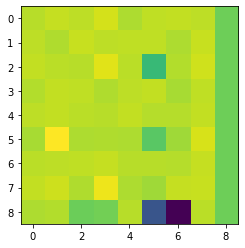

In [67]:
plt.imshow(v_a_h.sum(dim=[0,-1]).detach().numpy())